### Import all the dependencies

In [1]:
# import all libraries 
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import gensim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Preprocessing: Load all datasets

In [2]:
airbnb_reviews = pd.read_feather('data/airbnb_reviews.feather').drop('index', axis=1)
air_bnb_ret_new = pd.read_feather('data/air_bnb_ret_new.feather').drop('index', axis=1)
airbnb_reviews_en = pd.read_feather('data/airbnb_reviews_en.feather').drop('index', axis=1)
airbnb_reviews_en_join = pd.read_feather('data/airbnb_reviews_en_join.feather').drop('index', axis=1)



In [3]:
doc2vec50 = pd.read_feather('data/airbnb_reviews_en_doc2vec50.feather').drop('index', axis=1)

In [4]:
doc2vec50_join = pd.read_feather('data/airbnb_reviews_en_join_doc2vec50.feather')

In [5]:
doc2vec50_join.head(2)

,index,listing_id,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,0,488835,-0.172850,0.054249,1.331955,0.624849,-0.289155,0.352968,-0.168172,-0.026205,...,-0.313929,0.960765,-0.409866,0.665558,-1.174518,0.394543,-0.461035,0.561439,0.387918,-0.116501
1,1,549036,-1.000408,-1.492268,1.580612,1.604159,0.080560,2.180467,-0.874364,0.136403,...,-0.852686,-0.180197,-0.088430,0.152311,-2.935486,1.093438,1.591154,0.095329,1.272898,-0.357847


### Preprocessing: Create the 'Average score' for the rating dataset

In [6]:
air_bnb_ret_new['Average score'] = air_bnb_ret_new.iloc[:,-7:-1].sum(axis=1)/6
air_bnb_ret_new = air_bnb_ret_new[air_bnb_ret_new['Average score'] > 0]

In [7]:
air_bnb_ret_new.shape

(295626, 36)

In [8]:
air_bnb_ret_new.head(1)

,Listing ID,Name,Host ID,Host Name,Host Response Rate,Host Is Superhost,Host total listings count,Street,City,Neighbourhood cleansed,...,Last Review Date,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per month,Average score
0,5534229.0,A 2 Passi da San Pietro,28697142.0,Veronica,100%,False,5.0,00165| Rm 00165| Italy,165,XIII Aurelia,...,8/29/15,90,9.0,10.0,8.0,8.0,9.0,9.0,0.08,8.833333


### Preprocessing: Remove outliers for the rating dataset

In [9]:
air_bnb_ret_new = air_bnb_ret_new.loc[(2 <= air_bnb_ret_new.Price) 
                                       &(air_bnb_ret_new.Price <= 256) 
                                       &(air_bnb_ret_new.Bedrooms) != 0
                                       &(1 <= air_bnb_ret_new['Minimum nights'])
                                       &(1 <= air_bnb_ret_new['Maximum nights'])
                                       &(air_bnb_ret_new['Minimum nights'] <= 64)
                                       &(air_bnb_ret_new['Maximum nights'] <= 128)]

In [10]:
air_bnb_ret_new.shape

(251574, 36)

### Merge the rating dataset with the doc2vec50 dataset

In [11]:
meta = pd.merge(air_bnb_ret_new,doc2vec50_join, left_on='Listing ID', right_on='listing_id').drop('listing_id',axis=1)
meta.head(1)


,Listing ID,Name,Host ID,Host Name,Host Response Rate,Host Is Superhost,Host total listings count,Street,City,Neighbourhood cleansed,...,40,41,42,43,44,45,46,47,48,49
0,5534229.0,A 2 Passi da San Pietro,28697142.0,Veronica,100%,False,5.0,00165| Rm 00165| Italy,165,XIII Aurelia,...,0.060384,0.289995,0.194011,0.046596,-0.234815,0.034182,0.060044,0.189014,-0.187465,-0.048451


In [12]:
meta.shape

(210285, 87)

### PCA Plot for joined comments

In [13]:
columns = [str(i) for i in range(50)]
doc2vec50 = meta[columns]

In [14]:
x = doc2vec50.values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [15]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc_1', 'pc_2'])

In [16]:
principalDf.head(1)

,pc_1,pc_2
0,-0.065801,-0.097752


In [17]:
meta = pd.concat([meta,principalDf],axis=1)

In [18]:
meta.head(1)

,Listing ID,Name,Host ID,Host Name,Host Response Rate,Host Is Superhost,Host total listings count,Street,City,Neighbourhood cleansed,...,42,43,44,45,46,47,48,49,pc_1,pc_2
0,5534229.0,A 2 Passi da San Pietro,28697142.0,Veronica,100%,False,5.0,00165| Rm 00165| Italy,165,XIII Aurelia,...,0.194011,0.046596,-0.234815,0.034182,0.060044,0.189014,-0.187465,-0.048451,-0.065801,-0.097752


In [19]:
meta['is_high_rat'] = meta['Average score'] == 10
meta['is_high_rat'] = meta['is_high_rat'].astype(int)


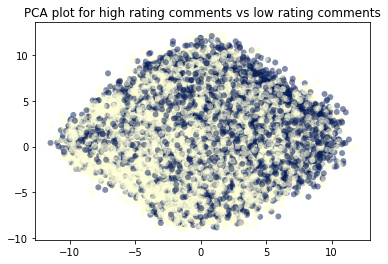

In [20]:
plt.scatter(meta['pc_1'], meta['pc_2'], edgecolor='none', alpha=0.5, c=meta['is_high_rat'], cmap='YlGnBu')
plt.title('PCA plot for high rating comments vs low rating comments')

plt.savefig('plots/PCA plot for high rating comments vs low rating comments.png')


plt.show()

### PCA Plot for all comments

In [21]:
columns = [str(i) for i in range(50)]
doc2vec50 = doc2vec50[columns]

In [22]:
# Separating out the features
x = doc2vec50.values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [23]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc_1', 'pc_2'])



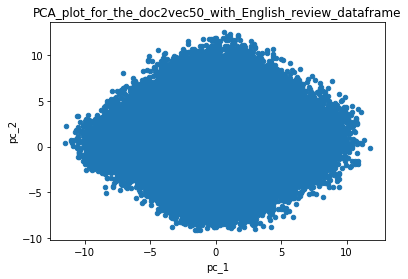

In [24]:
principalDf.plot.scatter(x='pc_1', y='pc_2')
plt.title('PCA_plot_for_the_doc2vec50_with_English_review_dataframe')

plt.savefig('plots/PCA_plot_for_the_doc2vec50_with_English_review_dataframe.png')


plt.show()